### **Due Date**
2/17/2025 at 11:59PM EST

# **Introduction**

Welcome to Assignment 2 of CS 4756/5756. In this assignment, you will train an agent using demonstrations from an expert. Concretely, you will:
* Implement behavior cloning (BC)
* **CS 5756 Only:** Implement dataset aggregation (DAgger)

You will use the Fetch agent for this assignment (Reach task), which is part of Gymasium Robotics' Mujoco Environments. Refer to the Gym website for more details about the [Fetch Reach environment](https://robotics.farama.org/envs/fetch/reach/).


Please read through the following paragraphs carefully, as they will apply to this and all future assignments.

**Getting Started:** This assignment should be completed in [Google Colab](https://colab.research.google.com/). In order to visualize the environment rollouts, you may switch your runtime to the T4 GPU - however, it is not required for completion of the assignment.

**Evaluation:**
Your code will be tested for correctness and, for certain assignments, speed. For this particular assignment, performance results will not be harshly graded (although we provide approximate expected reward numbers as lower bounds, you are not expected to replicate them exactly); however, it will be important to make an effort to justify your approach which led to the obtained results. Please remember that all assignments should be completed individually.

**Academic Integrity:** We will be checking your code against other submissions in the class for logical redundancy. If you copy someone else’s code and submit it with minor changes, we will know. These cheat detectors are quite hard to fool, so please don’t try. We trust you all to submit your own work only; please don’t let us down. If you do, we will pursue the strongest consequences available to us.

**Getting Help:** The [Resources](https://www.cs.cornell.edu/courses/cs4756/2024sp/#resources) section on the course website is your friend! If you ever feel stuck in these projects, please feel free to avail yourself to office hours and Edstem! If you are unable to make any of the office hours listed, please let TAs know and we will be happy to assist. If you need a refresher for PyTorch, please see this [60 minute blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)! For Numpy, please see the quickstart [here](https://numpy.org/doc/stable/user/quickstart.html) and full API [here](https://numpy.org/doc/stable/reference/).


# Installation and Setup

In [1]:
!pip install "cython<3"
!git clone https://github.com/Farama-Foundation/Gymnasium-Robotics.git
!pip install -e Gymnasium-Robotics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.1 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12
Cloning into 'Gymnasium-Robotics'...
remote: Enumerating objects: 7633, done.
remote: Counting objects: 100% (2338/2338), done.
remote: Compressing objects: 100% (594/594), done.
remote: Total 7633 (delta 2042), reused 1777 (delta 1700), pack-reused 5295 (from 3)
Receiving objects: 100% (7633/7633), 402.05 MiB | 37.43 MiB/s, done.
Resolving deltas: 100% (4030/4030), done.
Updating files: 100% (356/356), done.
Obtaining file:///content/Gymnasium-Robotics
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [2]:
#Include this at the top of your colab code
import os
!rm .mujoco_setup_complete
if not os.path.exists('.mujoco_setup_complete'):
  # Get the prereqs
  !apt-get -qq update
  !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
  # Get Mujoco
  !rm -rf ~/.mujoco
  !mkdir ~/.mujoco
  !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
  !tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
  !rm mujoco.tar.gz
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' >> ~/.bashrc
  !echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> ~/.bashrc
  # THE ANNOYING ONE, FORCE IT INTO LDCONFIG SO WE ACTUALLY GET ACCESS TO IT THIS SESSION
  !echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
  !ldconfig
  # Install Mujoco-py
  !pip3 install -U 'mujoco-py<2.2,>=2.1'
  # run once
  !touch .mujoco_setup_complete


try:
  if _mujoco_run_once:
    pass
except NameError:
  _mujoco_run_once = False
if not _mujoco_run_once:
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  try:
    os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin'
  except KeyError:
    os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin'
  try:
    os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
  except KeyError:
    os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
  # presetup so we don't see output on first env initialization
  import mujoco_py
  _mujoco_run_once = True

rm: cannot remove '.mujoco_setup_complete': No such file or directory
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libglx-dev:amd64.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../00-libglx-dev_1.4.0-1_amd64.deb ...
Unpacking libglx-dev:amd64 (1.4.0-1) ...
Selecting previously unselected package libgl-dev:amd64.
Preparing to unpack .../01-libgl-dev_1.4.0-1_amd64.deb ...
Unpacking libgl-dev:amd64 (1.4.0-1) ...
Selecting previously unselected package libegl-dev:amd64.
Preparing to unpack .../02-libegl-dev_1.4.0-1_amd64.deb ...
Unpacking libegl-dev:amd64 (1.4.0-1) ...
Selecting previously unselected package libgl1-mesa-glx:amd64.
Preparing to unpack .../03-libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~2

INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.11/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_311_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-311/usr/local/lib/python3.11/dist-packages/mujoco_py
INFO:root:creating /usr/local/lib/python3.11/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_311_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-311/usr/local/lib/python3.11/dist-packages/mujoco_py/gl
INFO:root:x86_64-linux-gnu-gcc -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.11/dist-packages/mujoco_py -I/root/.mujoco/mujoco210/include -I/usr/local/lib/python3.11/dist-packages/numpy/core/include -I/usr/include/python3.11 -c /usr/local/lib/python3.11/dist-packages/mujoco_py/cymj.c -o /usr/local/lib/python3.11/dist-packages/mujoco_py/generated/_pyxbld_2.1.2.14_311_linuxcpuextensionbuilder/temp.linux-x86_

In [ ]:
import torch
if torch.cuda.is_available():
    print("GPU is available")
    !pip install mujoco

    # Set up GPU rendering.
    from google.colab import files
    import distutils.util
    import os
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
            "file_format_version" : "1.0.0",
            "ICD" : {
                "library_path" : "libEGL_nvidia.so.0"
            }
        }
        """)

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl

    # Check if installation was succesful.
    try:
        print('Checking that the installation succeeded:')
        import mujoco
        mujoco.MjModel.from_xml_string('<mujoco/>')
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')

    print('Installation successful.')

    # Other imports and helper functions
    import time
    import itertools
    import numpy as np

    # Graphics and plotting.
    print('Installing mediapy:')
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
    !pip install -q mediapy
    import mediapy as media
    import matplotlib.pyplot as plt

    # More legible printing from numpy.
    np.set_printoptions(precision=3, suppress=True, linewidth=100)

    from IPython.display import clear_output
    clear_output()


In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install renderlab

In [ ]:
import sys
sys.path.append('/content/Gymnasium-Robotics')
import gymnasium as gym
import gymnasium_robotics
import renderlab as rl

ROBOT_PROPRIOCEPTION_KEY = 'observation'
ROBOT_XYZ_GOAL_KEY = 'desired_goal'

### **Downloading Expert File**


In [ ]:
!wget https://github.com/kuanfang/cornell-cs4756-2025sp/raw/main/assignments/A1/programming/expert.pt

# **Environment and Expert Setup**
The environment is held in ```env``` and the expert agent is held in ```actor_network```.






In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def process_inputs(o, g, o_mean, o_std, g_mean, g_std, clip_obs, clip_range):
    o_clip = np.clip(o, -clip_obs, clip_obs)
    g_clip = np.clip(g, -clip_obs, clip_obs)
    o_norm = np.clip((o_clip - o_mean) / (o_std), -clip_range, clip_range)
    g_norm = np.clip((g_clip - g_mean) / (g_std), -clip_range, clip_range)
    inputs = np.concatenate([o_norm, g_norm])
    inputs = torch.tensor(inputs, dtype=torch.float32)
    return inputs


# define the Expert network
class Expert(nn.Module):
    def __init__(self, env_params, o_mean, o_std, g_mean, g_std):
        super(Expert, self).__init__()
        self.max_action = env_params['action_max']
        self.fc1 = nn.Linear(env_params[ROBOT_PROPRIOCEPTION_KEY] + env_params[ROBOT_XYZ_GOAL_KEY], 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.action_out = nn.Linear(256, env_params['action'])
        self.o_mean = o_mean
        self.o_std = o_std
        self.g_mean = g_mean
        self.g_std = g_std
        self.clip_obs = 200
        self.clip_range = 5

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        actions = self.max_action * torch.tanh(self.action_out(x))

        return actions

    def get_expert_action(self, prop, g):
        inputs = process_inputs(prop, g, self.o_mean, self.o_std, self.g_mean, self.g_std, self.clip_obs, self.clip_range).to(device)
        pi = self.forward(inputs)
        action = pi.detach().cpu().numpy().squeeze()
        return action



## **Notes about Fetch Reach Environment**
The environment uses a Fetch Robot, which is a 7-DoF Mobile Manipulator.

The task is a *goal-reaching task*:
The observation space is a dictionary which contains the robot's proprioception (under the key `ROBOT_PROPRIOCEPTION_KEY`), and the xyz coordinate that the robot's gripper aims to reach (under the key `ROBOT_GOAL_XYZ_KEY`).

All agents have functions defined which take the two pieces of data in order to predict an action to take.

See https://robotics.farama.org/envs/fetch/reach/ for more details.

If the goal is reached, `info['is_success']` will be set to 1, and this is an indication that we should terminate the rollout.

The reward (used only for evaluation in this assignment) is -1 per timestep spent in the environment without completing the task, with 50 steps being the limit (so -50 is the worst episode return).

In [ ]:
print(device)
model_path = "expert.pt"
o_mean, o_std, g_mean, g_std, model = torch.load(model_path, map_location=lambda storage, loc: storage)
model
# create the environment
env = gym.make('FetchReach-v4', render_mode='rgb_array')# get the env param
observation, _ = env.reset()

# get the environment params
env_params = {ROBOT_PROPRIOCEPTION_KEY: observation[ROBOT_PROPRIOCEPTION_KEY].shape[0],
                ROBOT_XYZ_GOAL_KEY: observation[ROBOT_XYZ_GOAL_KEY].shape[0],
                'action': env.action_space.shape[0],
                'action_max': env.action_space.high[0],
                }
# create the Expert network
expert_network = Expert(env_params, o_mean, o_std, g_mean, g_std)
expert_network.to(device)
expert_network.load_state_dict(model)
expert_network.eval()

In [ ]:
import mujoco_py
import torch.nn as nn
import torch
import numpy as np
import random
import tqdm
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import optimizer
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
# Setting the seed to ensure reproducability
def reseed(seed):
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)

reseed(42)

# **Example Demonstration Rollouts**
### **Visualizing the Fetch Reach environment**

We have provided functions to visualize the environment and compute rewards on the Fetch Reach environment with random actions or expert actions. Looking through this code will help you get familiarized with the environment, and set you up for the next parts in this assignment.

We disabled the visualizations by default since they greatly slow down the evaluation, but feel free to turn it on if you're interested. You'll have to set visualize to True in the cell below and render_mode to 'rgb_array' when setting up the environment. Note that visualization will only be possible if T4 GPU runtime is available.

In [ ]:
NUM_TRAJS = 10
visualize = False and torch.cuda.is_available() # set to false in order to disable rendering code
if visualize:
    env = rl.RenderFrame(env, './output')
if visualize:
    plt.axis('off')
total_reward_random = 0
i = 0

for k in range(NUM_TRAJS):
  done = False
  observation, info = env.reset(seed = k)
  while not done:
    i += 1
    if visualize and i%5==0:
      ipythondisplay.clear_output(wait=True)
      screen = env.render()
      plt.imshow(screen)
      ipythondisplay.display(plt.gcf())
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated or info['is_success']
    total_reward_random += reward
    if done:
        break
total_reward_random /= NUM_TRAJS
print(f"Avg Reward using Random Actions = ", (total_reward_random))

In [ ]:
NUM_TRAJS = 10
visualize = True and torch.cuda.is_available() # set to false in order to disable rendering code
if visualize:
    env = rl.RenderFrame(env, './output')
if visualize:
    plt.axis('off')
total_reward = 0
i = 0

for k in range(NUM_TRAJS):
  done = False
  observation, info = env.reset(seed = k)
  while not done:
    i += 1
    if visualize and i%5==0:
      ipythondisplay.clear_output(wait=True)
      screen = env.render()
      plt.imshow(screen)
      ipythondisplay.display(plt.gcf())
    action = expert_network.get_expert_action(observation[ROBOT_PROPRIOCEPTION_KEY], observation[ROBOT_XYZ_GOAL_KEY])
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated or info['is_success']
    total_reward += reward
    if done:
        break
total_reward /= NUM_TRAJS
print(f"Avg Reward using Expert Actions = ", (total_reward))

**Approximate expected reward for total reward using random actions: -40 to -50**

**Approximate expected reward for total reward using expert actions: -2 to -3**

# **Defining Learner Agent Class**

In [ ]:
class Learner(nn.Module):
    def __init__(self, env, env_params, hidden_dim = 256, random_prob=0.0):
        super().__init__()
        self.fc1 = nn.Linear(env_params[ROBOT_PROPRIOCEPTION_KEY] + env_params[ROBOT_XYZ_GOAL_KEY], hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, env_params['action'])

        self.env = env
        self.random_prob = random_prob

    def forward(self, prop, g):
        x = torch.cat([prop, g], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = F.tanh(self.fc_out(x))
        return out

    def get_action(self, prop, g):
        if np.random.random() < self.random_prob:
            return self.env.action_space.sample()
        action = self.forward(torch.tensor(prop).unsqueeze(0).to(device).float(), torch.tensor(g).unsqueeze(0).to(device).float())
        return np.array(action[0].detach().cpu())

In [ ]:
def get_checkpoint_path(algo):
    """Return the path to save the best performing model checkpoint.

    Parameters:
        algo (str)
          Indicates which algorithm will be used to train the model

    Returns:
        checkpoint_path (str)
            The path to save the best performing model checkpoint
    """
    if algo == "bc":
      return 'best_bc_checkpoint.pth'
    elif algo == "dagger":
      return 'best_dagger_checkpoint.pth'
    return 'best_model_checkpoint.pth'

# **Collect Expert Demonstrations**

In [ ]:
### Collecting trajectories (i.e. demonstrations) using the expert policy
NUM_TRAJS = 12
proprios, goals, actions = [], [], []
reseed(1)
for traj_num in tqdm(range(NUM_TRAJS), position=0, leave=True):
    done = False
    observation, _ = env.reset(seed = traj_num)
    while not done:
        with torch.no_grad():
            action = expert_network.get_expert_action(observation[ROBOT_PROPRIOCEPTION_KEY], observation[ROBOT_XYZ_GOAL_KEY])
            proprios.append(observation[ROBOT_PROPRIOCEPTION_KEY])
            goals.append(observation[ROBOT_XYZ_GOAL_KEY])
            action[-1] = 0
            actions.append(action)
            observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated or info['is_success']
        if done:
            break
train_proprios = proprios[:int(0.5*len(proprios))]
train_goals = goals[:int(0.5*len(proprios))]
train_actions = actions[:int(0.5*len(actions))]
validation_proprios = proprios[int(0.5*len(proprios)):]
validation_goals = goals[int(0.5*len(proprios)):]
validation_actions = actions[int(0.5*len(actions)):]

# PART 1: (CS 4756/5756) **Implement and train BC Agent**

To begin, fill in the implementation for the training loop function in **`bc_train`**. We provide the loss function and optimizer already, just iterate through your dataloader and return the updated policy!

You'll also measure the validation loss at each iteration to check for overfitting.

Once you finish the training loop implementation, it is now time to build up your agents! **Behavior cloning (BC)** is the simplest imitation learning algorithm, where we perform supervised learning on the given (offline) expert dataset. We either do this via log-likelihood maximization (cross-entropy minimization) in the discrete action case, or mean-squared error minimization (can also do MLE) in the continuous control setting.

If implemented correctly, training your BC model should take at most 1 minute.

In [23]:
import gym
import tqdm
from tqdm import tqdm
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import optimizer

def evaluate(env, learner):
    NUM_TRAJS = 20
    total_learner_reward = 0
    for i in range(NUM_TRAJS):
        done = False
        observation, _ = env.reset(seed = i)
        while not done:
            action = learner.get_action(observation[ROBOT_PROPRIOCEPTION_KEY], observation[ROBOT_XYZ_GOAL_KEY])
            observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated or info['is_success']
            total_learner_reward += reward
            if done:
                break
    return total_learner_reward / NUM_TRAJS

def bc_train(learner, proprios, goals, actions, validation_proprios, validation_goals, validation_acts, checkpoint_path, num_epochs=100):
    """Train function for learning a new policy using BC.

    Parameters:
        learner (Learner)
            A Learner object (policy)
        proprios (list of torch.tensor)
            A list of pytorch arrays of shape (N, 10, )
        goals (list of torch.tensor)
            A list of pytorch arrays of shape (N, 3, )
        actions (list of torch.tensor)
            A list of pytorch arrays of shape (N, 4, )
        checkpoint_path (str)
            The path to save the best performing checkpoint
        num_epochs (int)
            Number of epochs to run the train function for

    Returns:
        learner (Learner)
            A Learner object (policy)
    """
    best_loss = float('inf')
    best_model_state = None

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(learner.parameters(), lr=3e-4)
    dataset = TensorDataset(proprios, goals, actions) # Create your dataset
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True) # Create your dataloader

    # TODO: Complete the training loop here ###
    loss = float('inf')
    validation_losses = []
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0
        for batch_idx, (prop, g, act) in enumerate(dataloader):
            optimizer.zero_grad()
            predicted_actions = learner(prop, g)
            loss = loss_fn(predicted_actions, act)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        with torch.no_grad():
            validation_loss = loss_fn(learner(validation_proprios, validation_goals), validation_acts)
            validation_losses.append(validation_loss)

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(learner.state_dict().copy(), checkpoint_path)
    if checkpoint_path == 'best_bc_checkpoint.pth':
        plt.plot(np.arange(0, num_epochs), [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in validation_losses])
        plt.title("Validation Loss vs. Iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Validation Loss")
        plt.savefig("BC_validation_loss.png")

    return learner

The resulting graph should show a clear downward trend without curving back up at the right side. If the validation loss increases at the end, it indicates overfitting.

100%|██████████| 1500/1500 [00:10<00:00, 140.51it/s]


Learner(
  (fc1): Linear(in_features=13, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=4, bias=True)
)

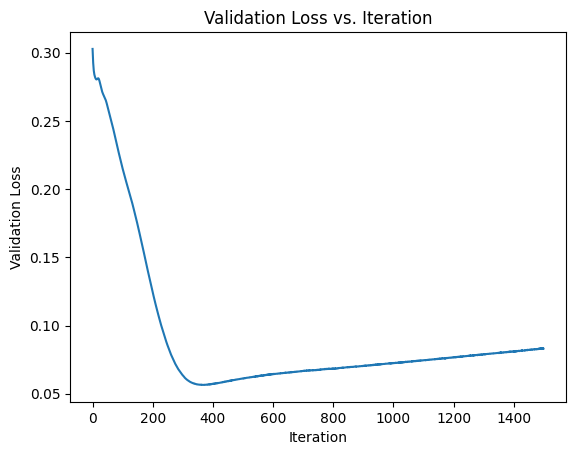

In [24]:
bc_learner = Learner(env, env_params)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bc_learner.to(device)
checkpoint_path = get_checkpoint_path("bc")
reseed(2)
bc_train(
    bc_learner,
    torch.tensor(train_proprios).to(device).float(),
    torch.tensor(train_goals).to(device).float(),
    torch.tensor(train_actions).to(device).float(),
    torch.tensor(validation_proprios).to(device).float(),
    torch.tensor(validation_goals).to(device).float(),
    torch.tensor(validation_actions).to(device).float(),
    checkpoint_path,
    num_epochs = 1500
)

### Evaluate the BC Agent's Performance
**Approximate expected reward for BC learner: -10 to -15**

In [25]:
bc_learner = Learner(env, env_params)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bc_learner.to(device)
checkpoint_path = get_checkpoint_path("bc")
bc_learner.load_state_dict(torch.load(checkpoint_path))
bc_learner.eval()

print("Avg Reward using Learner Actions = ", (evaluate(env, bc_learner)))
print("Avg Reward using Expert Actions = ", (total_reward))



  bc_learner.load_state_dict(torch.load(checkpoint_path))



Avg Reward using Learner Actions =  -11.5
Avg Reward using Expert Actions =  -1.8


# PART 2: (CS 5756 Only) **Implement and train DAgger Agent**

**Dataset aggregation (DAgger)** is a fundamentally interactive algorithm, where we can query the expert any time we want to get information about how to proceed. This allows for significantly more freedom for the learner, as it can ask the expert anywhere and not be limited by the dataset that it is given to learn from.

**Can we overcome suboptimal actions with DAgger?** Fundamentally, this algorithm allows the learner to recover from bad states and should lead to much better performance than simply behavior cloning a fixed set of expert demonstrations. For this portion of the assignment, you will interact with the environment using the learner policy with random actions. You will do so in **`interact`**.

The DAgger policy will be initialized with the already learned BC policy and your dataset with the already collected expert demonstrations for BC.

Training should take no longer than 2 minutes if implemented correctly.

In [26]:
def interact(env, learner, expert_network, proprios, goals, actions, validation_proprios, validation_goals, validation_actions, checkpoint_path, seed, num_epochs=100, horizon=50):
    """Interact with the environment and update the learner policy using DAgger.

    This function interacts with the given Gym environment and aggregates to
    the BC dataset by querying the expert.

    Parameters:
        env (Env)
            The gym environment (in this case, the Hopper gym environment)
        learner (Learner)
            A Learner object (policy)
        expert_network (Expert)
            An Expert object (expert policy)
        proprios (list of torch.tensor)
            A list of pytorch arrays of shape (N, 10, )
        goals (list of torch.tensor)
            A list of pytorch arrays of shape (N, 3, )
        actions (list of torch.tensor)
            A list of pytorch arrays of shape (N, 4, )
        checkpoint_path (str)
            The path to save the best performing model checkpoint
        seed (int)
            The seed to use for the environment
        num_epochs (int)
            Number of epochs to run the train function for
    """
    NUM_INTERACTIONS = 9
    best_reward = float('-inf')
    best_model_state = None
    for episode in range(NUM_INTERACTIONS):
        for _ in range(2):
            done = False
            observation, _ = env.reset(seed = episode)
            for _ in range(horizon):
                # TODO: Implement Fetch Reach environment interaction and dataset aggregation here
                #BEGIN SOLUTION
                action = learner.get_action(observation[ROBOT_PROPRIOCEPTION_KEY], observation[ROBOT_XYZ_GOAL_KEY])
                proprios = proprios.cpu() if isinstance(proprios, torch.Tensor) else proprios
                goals = goals.cpu() if isinstance(goals, torch.Tensor) else goals
                actions = actions.cpu() if isinstance(actions, torch.Tensor) else actions

                proprios = proprios.tolist() if isinstance(proprios, torch.Tensor) else proprios
                goals = goals.tolist() if isinstance(goals, torch.Tensor) else goals
                actions = actions.tolist() if isinstance(actions, torch.Tensor) else actions

                proprios.append(observation[ROBOT_PROPRIOCEPTION_KEY])
                goals.append(observation[ROBOT_XYZ_GOAL_KEY])

                expert_action = expert_network.get_expert_action(observation[ROBOT_PROPRIOCEPTION_KEY], observation[ROBOT_XYZ_GOAL_KEY])
                actions.append(expert_action)

                observation, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated or info['is_success']
                #END SOLUTION
                if done:
                    break
        bc_train(learner,
                 torch.tensor(proprios).to(device).float(),
                torch.tensor(goals).to(device).float(),
                torch.tensor(actions).to(device).float(),
                torch.tensor(validation_proprios).to(device).float(),
                torch.tensor(validation_goals).to(device).float(),
                torch.tensor(validation_actions).to(device).float(),
                 "DAgger_Interaction_{}.pth".format(episode), num_epochs)
        reward = evaluate(env, learner)
        print(f"After interaction {episode}, reward = {reward}")
        if reward > best_reward:
            best_reward = reward
            torch.save(learner.state_dict().copy(), checkpoint_path)

**Approximate expected reward for DAgger learner: -4 to -8**

In [27]:
# Initialize DAgger Agent with BC learner's weights
dagger_learner = Learner(env, env_params)
checkpoint_path = get_checkpoint_path("bc")
dagger_learner.load_state_dict(torch.load(checkpoint_path))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dagger_learner.to(device)

  dagger_learner.load_state_dict(torch.load(checkpoint_path))



Learner(
  (fc1): Linear(in_features=13, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=4, bias=True)
)

In [28]:
checkpoint_path = get_checkpoint_path("dagger")
seed = 2
reseed(seed)
interact(env, dagger_learner, expert_network, torch.tensor(train_proprios).to(device), torch.tensor(train_goals).to(device), torch.tensor(train_actions).to(device), torch.tensor(validation_proprios).to(device), torch.tensor(validation_goals), torch.tensor(validation_actions).to(device), checkpoint_path, seed, num_epochs = 500)

  torch.tensor(validation_proprios).to(device).float(),

  torch.tensor(validation_goals).to(device).float(),

  torch.tensor(validation_actions).to(device).float(),

100%|██████████| 500/500 [00:01<00:00, 276.08it/s]


After interaction 0, reward = -18.6


100%|██████████| 500/500 [00:01<00:00, 266.56it/s]


After interaction 1, reward = -18.6


100%|██████████| 500/500 [00:01<00:00, 271.18it/s]


After interaction 2, reward = -18.55


100%|██████████| 500/500 [00:01<00:00, 279.46it/s]


After interaction 3, reward = -18.55


100%|██████████| 500/500 [00:01<00:00, 273.63it/s]


After interaction 4, reward = -18.55


100%|██████████| 500/500 [00:01<00:00, 284.17it/s]


After interaction 5, reward = -18.55


100%|██████████| 500/500 [00:01<00:00, 259.44it/s]


After interaction 6, reward = -13.8


100%|██████████| 500/500 [00:02<00:00, 219.30it/s]


After interaction 7, reward = -6.9


100%|██████████| 500/500 [00:02<00:00, 174.01it/s]


After interaction 8, reward = -4.8


In [29]:
dagger_learner = Learner(env, env_params)
checkpoint_path = get_checkpoint_path("dagger")
dagger_learner.load_state_dict(torch.load(checkpoint_path))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dagger_learner.to(device)
dagger_learner.eval()

print("Avg Reward using DAgger Learner Actions = ", (evaluate(env, dagger_learner)))
print("Avg Reward using Expert Actions = ", (total_reward))

  dagger_learner.load_state_dict(torch.load(checkpoint_path))



Avg Reward using DAgger Learner Actions =  -4.8
Avg Reward using Expert Actions =  -1.8
